In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from collections import Counter
import numpy as np
import itertools
from pathlib import Path
import pandas as pd
from collections import Counter
from itertools import product
import numpy as np, pandas as pd, re
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

In [13]:
def load_fasta_to_dataframe(paths: list[Path]) -> pd.DataFrame:
    all_dfs = []
    for path in paths:
        seqs, labs = [], []
        lines = path.read_text().splitlines()
        for i in range(0, len(lines), 2):
            header = lines[i].strip()
            if not header:
                continue
            seq  = lines[i+1].strip() if i+1 < len(lines) else ""
            labs.append("Positive" if "positive" in header.lower() or header == ">1" else "Negative")
            seqs.append(seq.upper())
        all_dfs.append(pd.DataFrame({"seq": seqs, "label": labs}))

    return pd.concat(all_dfs, ignore_index=True)

data_dir = Path("/kaggle/input/oric-training")
files = ["bmark-K562_Human.txt", "bmark-MCF7_Human.txt"]
merged_df = load_fasta_to_dataframe([data_dir / f for f in files])
merged_df.head()

,seq,label
0,TGGAGGTACCTGCTCTCCACGCAGTACAGCATCTGGCTGTGTGGTG...,Positive
1,CAGCCCAGCCCCTCCAGGGCTCTGAGAGAGTTGTCTCCCAGGCCCA...,Positive
2,CCGGTCCGAAGGGCAAATAGTCTCGGGTCTCTCCGATTTCCCGAAC...,Positive
3,AGAGGGAGGGGCCGACGTGTGGGAGAGGGAAGGAAAGGGGGAGGAG...,Positive
4,GCTCCGGCCGCTGACGCCAAAATAGGGAAGGCCGGAAGCGGCGGGG...,Positive


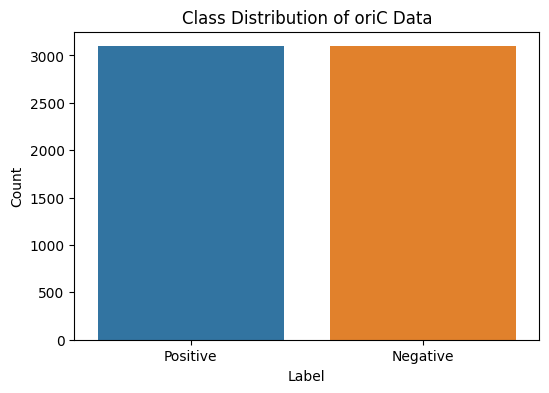

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=merged_df)
plt.title('Class Distribution of oriC Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vivym/DNABERT-2-117M", trust_remote_code=True)

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

class DNADataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

# Convert labels to numerical values
label_map = {'Positive': 1, 'Negative': 0}
merged_df['num_label'] = merged_df['label'].map(label_map)

# Split dataset into train (60%), validation (20%), and test (20%)
# First split: 80% for training+validation, 20% for testing
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    merged_df['seq'], merged_df['num_label'], 
    test_size=0.2, random_state=42, stratify=merged_df['num_label']
)

# Second split: Split the 80% into 75% training and 25% validation (which gives 60% train, 20% val)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, 
    test_size=0.25, random_state=42, stratify=train_val_labels
)

# Create DataLoaders for all three sets
train_dataset = DNADataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = DNADataset(val_texts.tolist(), val_labels.tolist(), tokenizer)
test_dataset = DNADataset(test_texts.tolist(), test_labels.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [17]:
print("train val split :", len(train_texts), len(val_texts), len(test_texts))

train val split : 3713 1238 1238


In [18]:
from transformers import AutoModelForSequenceClassification
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "vivym/DNABERT-2-117M",
    trust_remote_code=True,
    output_attentions=False,
    output_hidden_states=False
)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(device)

/root/.cache/huggingface/modules/transformers_modules/vivym/DNABERT-2-117M/b932e9ffdb5a2fc4e3577a0a184c22324d8fe750/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at vivym/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(4096, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertUnpadAttention(
              (self): BertUnpadSelfAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (mlp): BertGatedLi

In [19]:
from transformers import get_linear_schedule_with_warmup
import torch.optim as optim 

epochs = 7
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Epoch 1/7 | Train Loss: 0.4571 | Val Loss: 0.4262 | Val Accuracy: 0.8134


Epoch 2/7 | Train Loss: 0.3313 | Val Loss: 0.3643 | Val Accuracy: 0.8465


Epoch 3/7 | Train Loss: 0.2641 | Val Loss: 0.3888 | Val Accuracy: 0.8514
EarlyStopping counter: 1 out of 3


Epoch 4/7 | Train Loss: 0.2000 | Val Loss: 0.5589 | Val Accuracy: 0.8352
EarlyStopping counter: 2 out of 3


Epoch 5/7 | Train Loss: 0.1403 | Val Loss: 0.6512 | Val Accuracy: 0.8279
EarlyStopping counter: 3 out of 3
Early stopping triggered after epoch 5
Loaded best model with validation loss: 0.3643


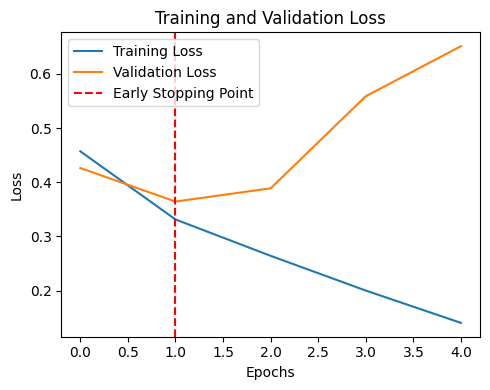


Evaluating on test set...



Test Results (Best Model):
Test Loss: 0.3300
Test Accuracy: 0.8603

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.89      0.86       619
    Positive       0.88      0.83      0.86       619

    accuracy                           0.86      1238
   macro avg       0.86      0.86      0.86      1238
weighted avg       0.86      0.86      0.86      1238


Confusion Matrix:
[[551  68]
 [105 514]]


In [20]:
import warnings
# Suppress specific DataParallel warning
warnings.filterwarnings("ignore", message="Was asked to gather along dimension 0, but all input tensors were scalars")

import copy
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm, trange

# Initialize lists to track metrics
train_losses = []
val_losses = []
val_accuracies = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
best_model_state = None
counter = 0
early_stopped = False

# Training loop with progress bars and early stopping
for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0
    
    # Create progress bar for training
    training_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)
    
    for batch in training_progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        if torch.cuda.device_count() > 1:
            loss = loss.mean()
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        training_progress.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_preds, val_labels_list = [], []
    total_val_loss = 0
    
    validation_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Validation]', leave=False)
    
    with torch.no_grad():
        for batch in validation_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            if torch.cuda.device_count() > 1:
                loss = loss.mean()
                
            total_val_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    accuracy = accuracy_score(val_labels_list, val_preds)
    val_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {accuracy:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the best model state
        if torch.cuda.device_count() > 1:
            best_model_state = copy.deepcopy(model.module.state_dict())
        else:
            best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} out of {patience}")
        
    if counter >= patience:
        print(f"Early stopping triggered after epoch {epoch+1}")
        early_stopped = True
        break

# Load the best model for evaluation
if best_model_state is not None:
    if torch.cuda.device_count() > 1:
        model.module.load_state_dict(best_model_state)
    else:
        model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

# Plot training/validation curves
plt.figure(figsize=(5, 4))

# Loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
if early_stopped:
    plt.axvline(x=len(val_losses)-patience-1, color='r', linestyle='--', label='Early Stopping Point')
plt.legend()
plt.tight_layout()
plt.show()

# Final evaluation on test set using the best model
print("\nEvaluating on test set...")
model.eval()
test_preds, test_labels_list = [], []
total_test_loss = 0

test_progress = tqdm(test_loader, desc='Test Evaluation', leave=False)

with torch.no_grad():
    for batch in test_progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        if torch.cuda.device_count() > 1:
            loss = loss.mean()
            
        total_test_loss += loss.item()
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Calculate metrics
avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = accuracy_score(test_labels_list, test_preds)

print(f"\nTest Results (Best Model):")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels_list, test_preds, target_names=['Negative', 'Positive']))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels_list, test_preds))


Processing Human datasets...
Loaded 4000 sequences for Human
Class distribution: {'Positive': 2000, 'Negative': 2000}


Evaluating Human: 100%|██████████| 250/250 [00:39<00:00,  6.31it/s]



Human Results:
Accuracy: 0.8498

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85      2000
    Positive       0.87      0.82      0.84      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000


Confusion Matrix:
[[1761  239]
 [ 362 1638]]

Processing Mouse datasets...
Loaded 6000 sequences for Mouse
Class distribution: {'Positive': 3000, 'Negative': 3000}


Evaluating Mouse: 100%|██████████| 375/375 [00:58<00:00,  6.39it/s]



Mouse Results:
Accuracy: 0.5672

Classification Report:
              precision    recall  f1-score   support

    Negative       0.54      0.93      0.68      3000
    Positive       0.75      0.20      0.32      3000

    accuracy                           0.57      6000
   macro avg       0.64      0.57      0.50      6000
weighted avg       0.64      0.57      0.50      6000


Confusion Matrix:
[[2798  202]
 [2395  605]]

Processing FF datasets...
Loaded 16000 sequences for FF
Class distribution: {'Positive': 8000, 'Negative': 8000}


Evaluating FF: 100%|██████████| 1000/1000 [02:36<00:00,  6.38it/s]



FF Results:
Accuracy: 0.5110

Classification Report:
              precision    recall  f1-score   support

    Negative       0.51      0.95      0.66      8000
    Positive       0.59      0.07      0.12      8000

    accuracy                           0.51     16000
   macro avg       0.55      0.51      0.39     16000
weighted avg       0.55      0.51      0.39     16000


Confusion Matrix:
[[7624  376]
 [7448  552]]


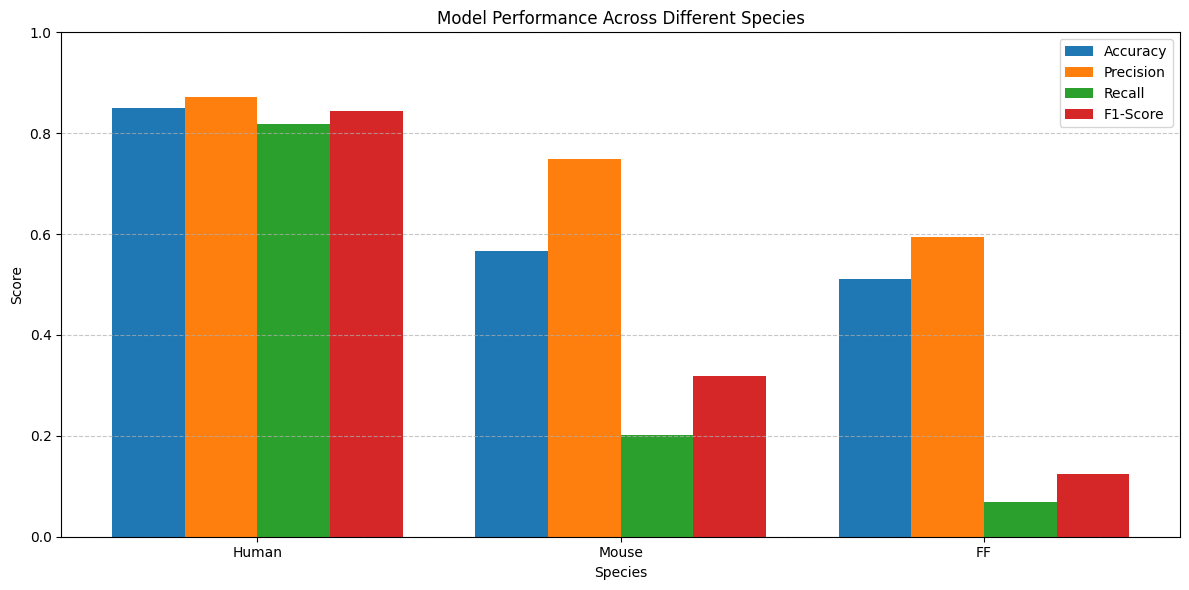

In [21]:
# Group files by species
independent_dir = Path("/kaggle/input/oric-independent")
species_files = {
    "Human": [independent_dir / "Ind-K562_Human.txt", independent_dir / "Ind-MCF7_Human.txt"],
    "Mouse": [independent_dir / "Ind-ES_Mouse.txt", independent_dir / "Ind-MEF_Mouse.txt", independent_dir / "Ind-P19_Mouse.txt"],
    "FF": [independent_dir / "Ind-Bg3_FF.txt", independent_dir / "Ind-KC_FF.txt", independent_dir / "Ind-S2_FF.txt"]
}

# Dictionary to store results for visualization
results = {}

# Process each species and test the model
for species, file_paths in species_files.items():
    print(f"\nProcessing {species} datasets...")
    
    # Load the data using the existing function
    species_df = load_fasta_to_dataframe(file_paths)
    print(f"Loaded {len(species_df)} sequences for {species}")
    print(f"Class distribution: {species_df['label'].value_counts().to_dict()}")
    
    # Convert labels to numerical values
    species_df['num_label'] = species_df['label'].map(label_map)
    
    # Create Dataset and DataLoader
    species_dataset = DNADataset(species_df['seq'].tolist(), species_df['num_label'].tolist(), tokenizer)
    species_loader = DataLoader(species_dataset, batch_size=16)
    
    # Evaluate model on this species
    model.eval()
    species_preds, species_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(species_loader, desc=f'Evaluating {species}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            species_preds.extend(preds.cpu().numpy())
            species_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(species_labels, species_preds)
    report = classification_report(species_labels, species_preds, target_names=['Negative', 'Positive'], output_dict=True)
    cm = confusion_matrix(species_labels, species_preds)
    
    # Store results for later visualization
    results[species] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm
    }
    
    # Print results for this species
    print(f"\n{species} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(species_labels, species_preds, target_names=['Negative', 'Positive']))
    print("\nConfusion Matrix:")
    print(cm)

# Visualize comparative results across species
plt.figure(figsize=(12, 6))

# Extract metrics for comparison
species_names = list(results.keys())
accuracies = [results[sp]['accuracy'] for sp in species_names]
precisions = [results[sp]['report']['Positive']['precision'] for sp in species_names]
recalls = [results[sp]['report']['Positive']['recall'] for sp in species_names]
f1_scores = [results[sp]['report']['Positive']['f1-score'] for sp in species_names]

# Plot metrics
x = np.arange(len(species_names))
width = 0.2

plt.bar(x - width*1.5, accuracies, width, label='Accuracy')
plt.bar(x - width/2, precisions, width, label='Precision')
plt.bar(x + width/2, recalls, width, label='Recall')
plt.bar(x + width*1.5, f1_scores, width, label='F1-Score')

plt.xlabel('Species')
plt.ylabel('Score')
plt.title('Model Performance Across Different Species')
plt.xticks(x, species_names)
plt.legend()
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()